# UCR Dataset: SyntheticControl

**Dataset Homepage:** https://timeseriesclassification.com/description.php?Dataset=SyntheticControl.

### 1. Environment set-up

1. This notebook contains elements which render correctly in Jupyter interface. Open this notebook from an Amazon SageMaker Notebook Instance or Amazon SageMaker Studio.
1. Ensure that IAM role used has **AmazonSageMakerFullAccess**
1. Some hands-on experience using [Amazon SageMaker](https://aws.amazon.com/sagemaker/).
1. To use this algorithm successfully, ensure that:
    1. Either your IAM role has these three permissions and you have authority to make AWS Marketplace subscriptions in the AWS account used: 
        1. **aws-marketplace:ViewSubscriptions**
        1. **aws-marketplace:Unsubscribe**
        1. **aws-marketplace:Subscribe**  
    2. or your AWS account has a subscription to the [Time Series Classification (LSTM-FCN) Algorithm from AWS Marketplace](https://aws.amazon.com/marketplace/pp/prodview-vzxmyw25oqtx6).

To subscribe to the algorithm:
1. Open the algorithm listing page.
1. On the AWS Marketplace listing, click on the **Continue to subscribe** button.
1. On the **Subscribe to this software** page, review and click on **"Accept Offer"** if you agree with EULA, pricing, and support terms. 
1. Once you click on the **Continue to configuration** button and then choose a **region**, you will see a **Product ARN**. This is the algorithm ARN that you need to specify while training a custom ML model. **Copy the ARN corresponding to your region and specify the same in the following cell.**

In [1]:
algo_arn = "arn:aws:sagemaker:eu-west-1:661670223746:algorithm/lstm-fcn-algo-v1-9"

In [2]:
import sagemaker
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

# SageMaker session
sagemaker_session = sagemaker.Session()

# SageMaker role
role = sagemaker.get_execution_role()

# S3 bucket
bucket = sagemaker_session.default_bucket()

# EC2 instance
instance_type = "ml.m5.xlarge"

### 2. Data preparation

#### 2.1 Training dataset

Load the training data.

In [3]:
training_dataset = pd.DataFrame(data=np.genfromtxt("SyntheticControl_TRAIN.txt"))

In [4]:
training_dataset.shape

(300, 61)

In [5]:
training_dataset.head()

,0,1,2,3,4,5,6,7,8,9,...,51,52,53,54,55,56,57,58,59,60
0,1.0,-0.376936,1.224864,0.343874,0.328454,-0.337609,1.026514,-1.330996,-0.657800,1.446077,...,0.370712,-1.568165,1.021863,-1.429748,1.356966,1.372781,0.663558,0.918346,-1.311742,-1.197146
1,1.0,0.644406,0.413269,-0.862278,-1.497386,-0.421458,-0.214215,-1.292131,0.956898,-1.216140,...,1.317268,-0.802528,-1.121287,0.989319,-1.109687,0.219856,0.630034,1.398140,0.085742,0.024997
2,1.0,-0.978667,-0.406232,0.822429,-1.408242,-1.676734,-0.490632,1.404598,1.168600,-1.703254,...,-0.828783,-0.762884,1.382972,-0.869103,1.277252,-0.198967,0.966809,0.666129,0.106996,0.082715
3,1.0,-0.236537,-0.098175,0.367092,1.366860,0.498281,-0.300223,1.715634,0.902108,-0.218132,...,0.068904,-1.499604,0.406744,1.289153,-1.119731,-0.995985,1.651135,-1.187098,0.025463,-0.841518
4,1.0,1.490735,1.325243,1.626829,-0.317056,-1.098990,-0.022213,0.596980,1.667339,-0.206153,...,0.815065,1.029995,-1.496161,-1.167442,1.484208,-0.373020,-0.843281,-0.209794,0.137724,0.716542


In [6]:
training_dataset.iloc[:, 0].sort_values().unique()

array([1., 2., 3., 4., 5., 6.])

In [7]:
training_dataset.iloc[:, 0].rename(None).value_counts().sort_index()

1.0    50
2.0    50
3.0    50
4.0    50
5.0    50
6.0    50
Name: count, dtype: int64

Visualize the training data.

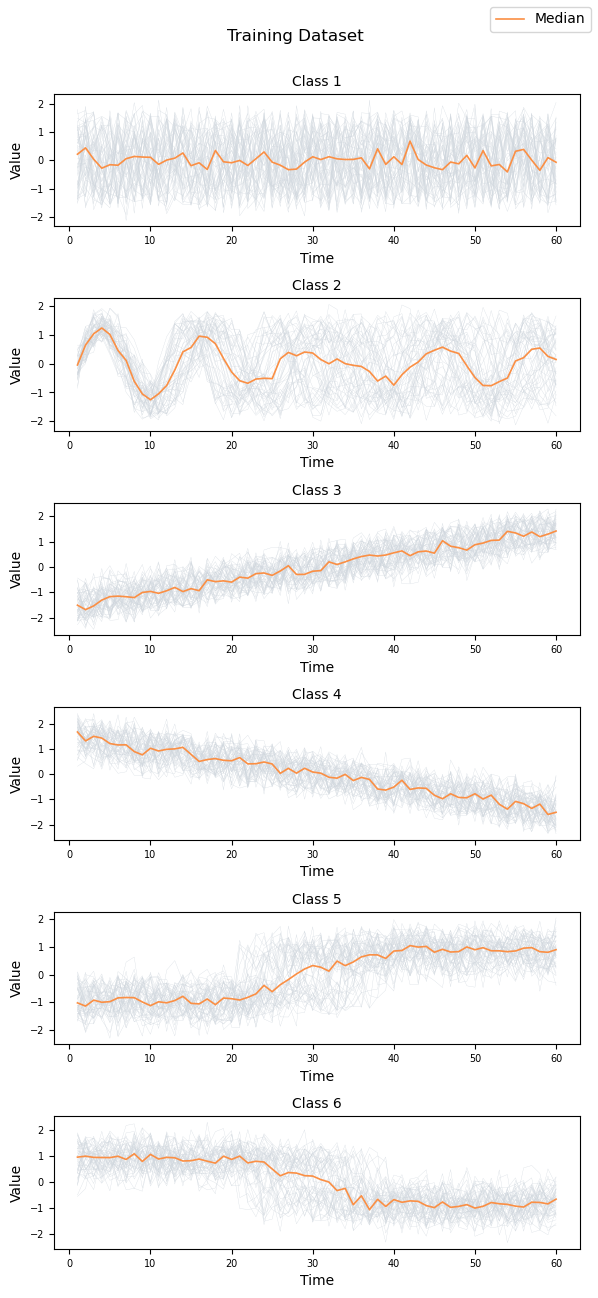

In [8]:
fig, axs = plt.subplots(nrows=training_dataset.iloc[:, 0].nunique(), ncols=1, sharex=True, figsize=(6, 13))
for i, c in enumerate(training_dataset.iloc[:, 0].sort_values().unique()):
    axs[i].plot(training_dataset[training_dataset.iloc[:, 0] == c].iloc[:, 1:].transpose(), color="#d0d7de", lw=0.2)
    axs[i].plot(training_dataset[training_dataset.iloc[:, 0] == c].iloc[:, 1:].transpose().median(axis=1), color="#fb8f44", lw=1.2, label="Median" if i == 0 else None)
    axs[i].set_title(f"Class {int(c)}", size=10)
    axs[i].set(xlabel="Time", ylabel="Value")
    axs[i].xaxis.set_tick_params(labelbottom=True)
    axs[i].tick_params(axis="both", which="major", labelsize=7)
    axs[i].tick_params(axis="both", which="minor", labelsize=7)
fig.suptitle("Training Dataset")
fig.legend()
fig.tight_layout()
fig.subplots_adjust(top=0.93)
fig.show()

Upload the training data to S3.

In [9]:
training_data = sagemaker_session.upload_string_as_file_body(
    body=training_dataset.to_csv(index=False, header=False),
    bucket=bucket,
    key="SyntheticControl_train.csv"
)

In [10]:
training_data

's3://sagemaker-eu-west-1-661670223746/SyntheticControl_train.csv'

#### 2.2 Test dataset

Load the test data.

In [11]:
test_dataset = pd.DataFrame(data=np.genfromtxt("SyntheticControl_TEST.txt"))

In [12]:
test_dataset.shape

(300, 61)

In [13]:
test_dataset.head()

,0,1,2,3,4,5,6,7,8,9,...,51,52,53,54,55,56,57,58,59,60
0,1.0,-1.413973,-1.162065,-0.624174,0.939604,-0.527501,0.574787,0.543176,1.748488,-0.505922,...,0.861244,0.404978,-0.894692,-0.363005,1.187356,-0.959220,-0.353210,1.363072,0.725540,-0.880089
1,1.0,-1.115918,0.237161,1.630814,-1.164521,-0.490658,-1.259363,-0.444532,-0.075867,0.501587,...,1.405396,-0.275376,-0.397296,0.536837,1.401524,0.813164,0.367139,-1.366535,-0.662661,-1.248914
2,1.0,-1.285745,-0.067465,-0.555322,1.265105,1.071486,-0.671687,0.165408,-1.248055,0.024684,...,-0.876705,1.650781,-0.942760,-1.383123,-0.764376,-1.370275,0.976808,-1.682904,0.891538,1.552039
3,1.0,0.104958,1.058988,1.413211,1.219300,0.025581,1.328026,1.506016,-1.324825,-0.477935,...,1.375449,0.154675,-1.795027,-0.244081,1.517773,1.541059,-1.187600,0.738079,0.205016,1.117345
4,1.0,-0.325845,0.276776,0.711680,1.336955,0.297444,1.209129,-0.468070,1.000695,0.689799,...,1.355817,-1.270352,0.029483,0.740501,0.656075,-1.647922,0.617990,-0.308325,1.294794,-1.177385


In [14]:
test_dataset.iloc[:, 0].sort_values().unique()

array([1., 2., 3., 4., 5., 6.])

In [15]:
test_dataset.iloc[:, 0].rename(None).value_counts().sort_index()

1.0    50
2.0    50
3.0    50
4.0    50
5.0    50
6.0    50
Name: count, dtype: int64

Visualize the test data.

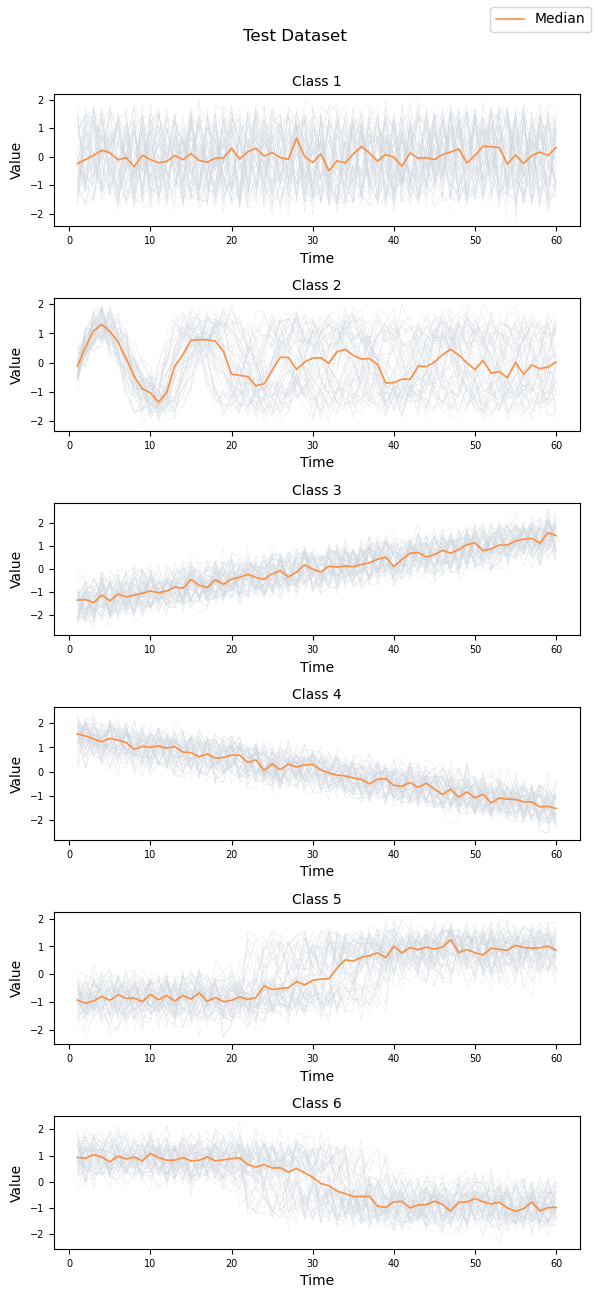

In [16]:
fig, axs = plt.subplots(nrows=test_dataset.iloc[:, 0].nunique(), ncols=1, sharex=True, figsize=(6, 13))
for i, c in enumerate(test_dataset.iloc[:, 0].sort_values().unique()):
    axs[i].plot(test_dataset[test_dataset.iloc[:, 0] == c].iloc[:, 1:].transpose(), color="#d0d7de", lw=0.2)
    axs[i].plot(test_dataset[test_dataset.iloc[:, 0] == c].iloc[:, 1:].transpose().median(axis=1), color="#fb8f44", lw=1.2, label="Median" if i == 0 else None)
    axs[i].set_title(f"Class {int(c)}", size=10)
    axs[i].set(xlabel="Time", ylabel="Value")
    axs[i].xaxis.set_tick_params(labelbottom=True)
    axs[i].tick_params(axis="both", which="major", labelsize=7)
    axs[i].tick_params(axis="both", which="minor", labelsize=7)
fig.suptitle("Test Dataset")
fig.legend()
fig.tight_layout()
fig.subplots_adjust(top=0.93)
fig.show()

Upload the test data to S3, make sure to remove the first column with the class labels.

In [17]:
test_data = sagemaker_session.upload_string_as_file_body(
    body=test_dataset.iloc[:, 1:].to_csv(index=False, header=False),
    bucket=bucket,
    key="SyntheticControl_test.csv"
)

In [18]:
test_data

's3://sagemaker-eu-west-1-661670223746/SyntheticControl_test.csv'

### 3. Training

Fit the model to the training data.

In [19]:
estimator = sagemaker.algorithm.AlgorithmEstimator(
    algorithm_arn=algo_arn,
    role=role,
    instance_count=1,
    instance_type=instance_type,
    input_mode="File",
    sagemaker_session=sagemaker_session,
    hyperparameters={
        "num-layers": 1,
        "hidden-size": 128,
        "dropout": 0.8,
        "filters-1": 128,
        "filters-2": 256,
        "filters-3": 128,
        "kernel-size-1": 8,
        "kernel-size-2": 5,
        "kernel-size-3": 3,
        "batch-size": 256,
        "lr": 0.01,
        "epochs": 200,
    },
)

estimator.fit({"training": training_data})

INFO:sagemaker:Creating training-job with name: lstm-fcn-algo-v1-9-2023-08-05-15-50-33-776


2023-08-05 15:50:33 Starting - Starting the training job...
2023-08-05 15:50:48 Starting - Preparing the instances for training......
2023-08-05 15:51:46 Downloading - Downloading input data...
2023-08-05 15:52:12 Training - Downloading the training image...........................
2023-08-05 15:56:43 Training - Training image download completed. Training in progress.bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2023-08-05 15:56:51,463 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2023-08-05 15:56:51,464 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2023-08-05 15:56:51,464 sagemaker-training-toolkit INFO     No Neurons detected (normal if no neurons installed)
2023-08-05 15:56:51,473 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2023-08-05 15:56:51,482 sagemaker_pytorch_container.training INFO     

### 4. Inference

Generate the test set predictions.

In [20]:
transformer = estimator.transformer(
    instance_count=1,
    instance_type=instance_type,
    max_payload=100,
)

transformer.transform(
    data=test_data,
    content_type="text/csv",
)

INFO:sagemaker:Creating model package with name: lstm-fcn-algo-v1-9-2023-08-05-15-58-49-933


.........

INFO:sagemaker:Creating model with name: lstm-fcn-algo-v1-9-2023-08-05-15-58-49--2023-08-05-15-59-35-381


INFO:sagemaker:Creating transform job with name: lstm-fcn-algo-v1-9-2023-08-05-15-59-38-733


..........................................
2023-08-05T16:06:40,721 [INFO ] main org.pytorch.serve.servingsdk.impl.PluginsManager - Initializing plugins manager...
2023-08-05T16:06:40,798 [INFO ] main org.pytorch.serve.metrics.configuration.MetricConfiguration - Successfully loaded metrics configuration from /opt/conda/lib/python3.10/site-packages/ts/configs/metrics.yaml
2023-08-05T16:06:40,908 [INFO ] main org.pytorch.serve.ModelServer - 
Torchserve version: 0.8.1
TS Home: /opt/conda/lib/python3.10/site-packages
Current directory: /
Temp directory: /home/model-server/tmp
Metrics config path: /opt/conda/lib/python3.10/site-packages/ts/configs/metrics.yaml
Number of GPUs: 0
Number of CPUs: 4
Max heap size: 3934 M
Python executable: /opt/conda/bin/python3.10
Config file: /etc/sagemaker-ts.properties
Inference address: http://0.0.0.0:8080
Management address: http://0.0.0.0:8080
Metrics address: http://127.0.0.1:8082
Model Store: /.sagemaker/ts/models
Initial Models: model=/opt/ml/model
Log

Load the test set predictions from S3.

In [21]:
predictions = sagemaker_session.read_s3_file(
    bucket=bucket,
    key_prefix=f"{transformer.latest_transform_job.name}/SyntheticControl_test.csv.out"
)

In [22]:
predictions = pd.DataFrame(data=predictions.split("\n")[:-1]).astype(float)

In [23]:
predictions.shape

(300, 1)

In [24]:
predictions.head()

,0
0,1.0
1,1.0
2,1.0
3,1.0
4,1.0


In [25]:
predictions.iloc[:, 0].sort_values().unique()

array([1., 2., 3., 4., 5., 6.])

In [26]:
predictions.iloc[:, 0].rename(None).value_counts().sort_index()

1.0    50
2.0    50
3.0    50
4.0    49
5.0    50
6.0    51
Name: count, dtype: int64

Calculate the classification metrics.

In [27]:
metrics = pd.DataFrame(classification_report(y_true=test_dataset.iloc[:, 0], y_pred=predictions.iloc[:, 0], output_dict=True))

In [28]:
metrics

,1.0,2.0,3.0,4.0,5.0,6.0,accuracy,macro avg,weighted avg
precision,1.0,1.0,0.98,1.000000,0.98,0.980392,0.99,0.990065,0.990065
recall,1.0,1.0,0.98,0.980000,0.98,1.000000,0.99,0.990000,0.990000
f1-score,1.0,1.0,0.98,0.989899,0.98,0.990099,0.99,0.990000,0.990000
support,50.0,50.0,50.00,50.000000,50.00,50.000000,0.99,300.000000,300.000000
